In [1]:
# Main imports
import curiosidade
import torch.nn
import torch


# Example-related imports
import collections
import functools

import torchmetrics
import tqdm.auto
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

/media/nvme/ulysses-curiosity/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Base model setup up

Typically your probed model will be already pretrained. In this simple example, we'll train a simple PyTorch model with a random dataset, and use this very same dataset as probing dataset. This is not an usual setup for probing tasks, but will help us to explore the main components of the library.

### Set up dataloaders

In [2]:
torch.random.manual_seed(32)

dataset_length, dataset_dimension = (400, 3)

X = torch.randn(dataset_length, dataset_dimension).float()
y = X.mean(axis=1).round().abs().long()

class_count = y.unique().numel()

print(f"{class_count = }")

class_count = 3


In [3]:
train_size = int(0.9 * dataset_length)
eval_size = int(0.05 * dataset_length)
test_size = dataset_length - train_size - eval_size

df = torch.utils.data.TensorDataset(X, y)
df_train, df_eval, df_test = torch.utils.data.random_split(
    df,
    lengths=[train_size, eval_size, test_size],
)

probing_dataloader_train = torch.utils.data.DataLoader(
    df_train,
    batch_size=8,
    shuffle=True,
)

probing_dataloader_eval = torch.utils.data.DataLoader(
    df_eval,
    batch_size=16,
    shuffle=False,
)

probing_dataloader_test = torch.utils.data.DataLoader(
    df_test,
    batch_size=16,
    shuffle=False,
)

### Set up probed (usually pretrained) model

In [4]:
class BaseModel(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.params = torch.nn.Sequential(
            collections.OrderedDict(
                (
                    ("lin1", torch.nn.Linear(dataset_dimension, 15, bias=True)),
                    ("relu1", torch.nn.ReLU(inplace=True)),
                    ("lin2", torch.nn.Linear(15, 25, bias=True)),
                    ("relu2", torch.nn.ReLU(inplace=True)),
                    ("lin3", torch.nn.Linear(25, 10, bias=True)),
                    ("relu3", torch.nn.ReLU(inplace=True)),
                    ("lin4", torch.nn.Linear(10, class_count)),
                )
            ),
        )

    def forward(self, X):
        return self.params(X)


probed_pretrained_model = BaseModel()
probed_optim = torch.optim.Adam(probed_pretrained_model.parameters(), lr=0.01)
probed_loss_fn = torch.nn.CrossEntropyLoss()
probed_num_train_epochs = 50

mov_avg_weight = 0.9
mov_avg_loss = 0.0

pbar = tqdm.auto.tqdm(range(1, 1 + probed_num_train_epochs))

for epoch in pbar:
    for X_batch, y_batch in probing_dataloader_train:
        probed_optim.zero_grad()
        y_logits = probed_pretrained_model(X_batch)
        loss = probed_loss_fn(input=y_logits, target=y_batch)
        loss.backward()
        probed_optim.step()

        mov_avg_loss = mov_avg_weight * mov_avg_loss + (1.0 - mov_avg_weight) * float(
            loss.cpu().detach().item()
        )

    pbar.set_description(f"{epoch=} of {probed_num_train_epochs} - {mov_avg_loss=:.3f}")

epoch=50 of 50 - mov_avg_loss=0.087: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 23.27it/s]


## Probing task setup

In [5]:
probing_model_fn = curiosidade.probers.utils.get_probing_model_feedforward(
    hidden_layer_dims=[20],
)

In [6]:
acc_fn = torchmetrics.Accuracy(num_classes=class_count)
f1_fn = torchmetrics.F1Score(num_classes=class_count)


def metrics_fn(logits: torch.Tensor, truth_labels: torch.Tensor) -> dict[str, float]:
    accuracy = acc_fn(logits, truth_labels).detach().cpu().item()
    f1 = f1_fn(logits, truth_labels).detach().cpu().item()
    return {"accuracy": accuracy, "f1": f1}


task = curiosidade.ProbingTaskCustom(
    probing_dataloader_train=probing_dataloader_train,
    probing_dataloader_eval=probing_dataloader_eval,
    probing_dataloader_test=probing_dataloader_test,
    labels_uri_or_map=y.unique(),
    loss_fn=torch.nn.CrossEntropyLoss(),
    task_name="task for overfitting (example #1)",
    task_type="classification",
    output_dim=class_count,
    metrics_fn=metrics_fn,
)

probing_factory = curiosidade.ProbingModelFactory(
    probing_model_fn=probing_model_fn,
    optim_fn=functools.partial(torch.optim.Adam, lr=0.001),
    task=task,
)

prober_container = curiosidade.attach_probers(
    base_model=probed_pretrained_model,
    probing_model_factory=probing_factory,
    modules_to_attach=["params.relu1", "params.relu3"],
    random_seed=16,
    prune_unrelated_modules="infer",
)

prober_container

ProbingModelContainer:
(a): Base model: InferencePrunerExtensor(TorchModuleAdapter(BaseModel(
 |  |  (params): Sequential(
 |  |    (lin1): Linear(in_features=3, out_features=15, bias=True)
 |  |    (relu1): ReLU(inplace=True)
 |  |    (lin2): Linear(in_features=15, out_features=25, bias=True)
 |  |    (relu2): ReLU(inplace=True)
 |  |    (lin3): Linear(in_features=25, out_features=10, bias=True)
 |  |    (relu3): ReLU(inplace=True)
 |  |    (lin4): Linear(in_features=10, out_features=3, bias=True)
 |  |  )
 |  |)))
 | (a): Pruned module(s) (1 in total):
 |   (0): params.lin4
 |
(b): Task name: task for overfitting (example #1)
(c): Probing dataset(s):
 | (train):   45 batches of size (at most) 8.
 | (eval) :    2 batches of size (at most) 16.
 | (test) :    2 batches of size (at most) 16.
(d): Probed module(s) (2 in total):
 | (0): params.relu1
 | (1): params.relu3

In [7]:
probing_results = prober_container.train(num_epochs=20, show_progress_bar=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.64it/s]


## Analyzing probing results

In [8]:
probing_results

ProbingResults(
    train = MetricPack with 5400 values stored in:
    (0, 'loss', 'params.relu1', 1): 1.0624488592147827
    (0, 'accuracy', 'params.relu1', 1): 0.625
    (0, 'f1', 'params.relu1', 1): 0.625
    ...
    (19, 'loss', 'params.relu3', 45): 0.011108070611953735
    (19, 'accuracy', 'params.relu3', 45): 1.0
    (19, 'f1', 'params.relu3', 45): 1.0,
    eval  = MetricPack with 240 values stored in:
    (0, 'loss', 'params.relu1', 1): 0.8883920311927795
    (0, 'accuracy', 'params.relu1', 1): 0.5625
    (0, 'f1', 'params.relu1', 1): 0.5625
    ...
    (19, 'loss', 'params.relu3', 2): 0.00045331227011047304
    (19, 'accuracy', 'params.relu3', 2): 1.0
    (19, 'f1', 'params.relu3', 2): 1.0,
    test  = MetricPack with 12 values stored in:
    (-1, 'loss', 'params.relu1', 1): 0.11611063778400421
    (-1, 'accuracy', 'params.relu1', 1): 1.0
    (-1, 'f1', 'params.relu1', 1): 1.0
    ...
    (-1, 'loss', 'params.relu3', 2): 0.0025872024707496166
    (-1, 'accuracy', 'params.relu3'

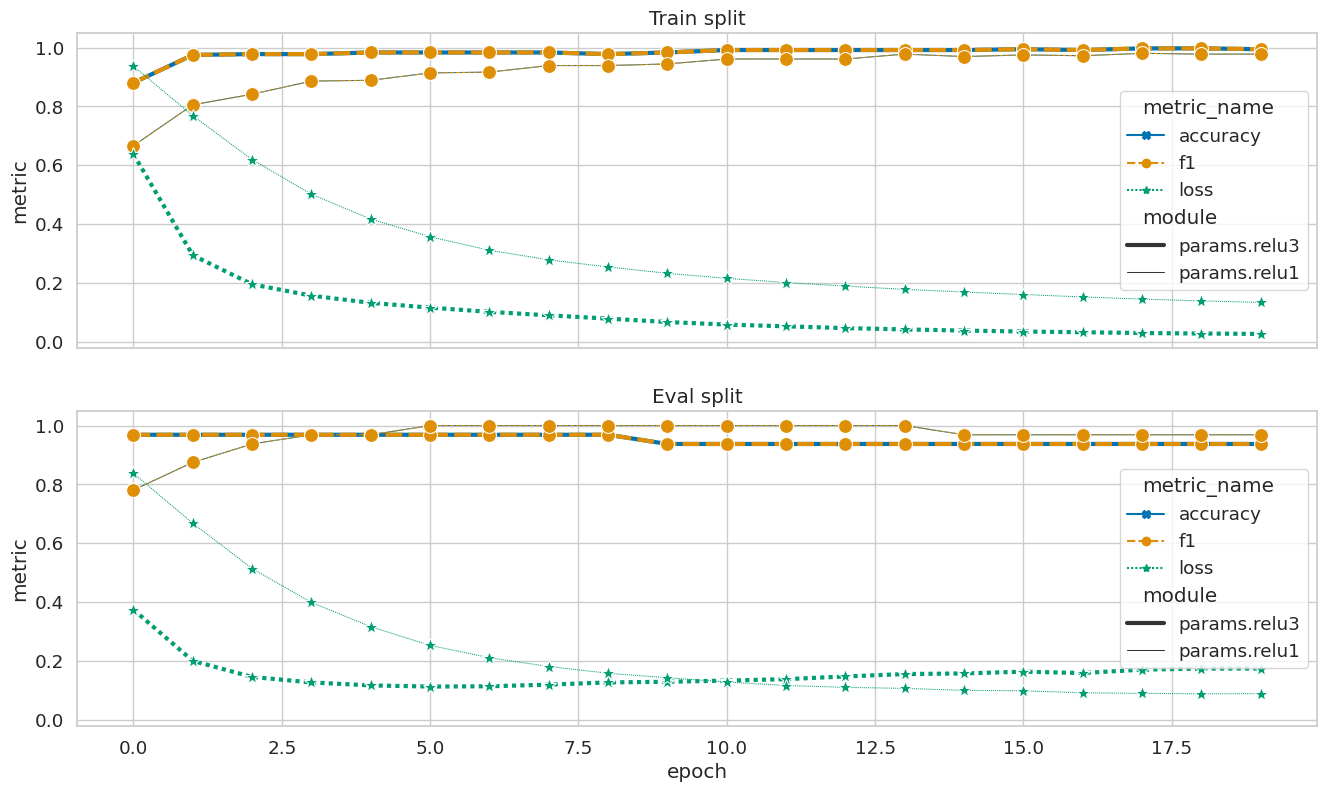

In [9]:
sns.set_theme(
    context="notebook",
    style="whitegrid",
    font_scale=1.2,
    palette="colorblind",
)

fig, (ax_train, ax_eval) = plt.subplots(2, figsize=(16, 9), sharex=True, sharey=True)

df_train, df_eval, df_test = probing_results.to_pandas(aggregate_by=["batch_index"])

common_kwargs = dict(
    hue="metric_name",
    y="metric",
    x="epoch",
    size="module",
    style="metric_name",
    markers=["X", "o", "*"],
    markersize=10,
    size_order=["params.relu3", "params.relu1"],
)

sns.lineplot(data=df_train, ax=ax_train, **common_kwargs)
sns.lineplot(data=df_eval, ax=ax_eval, **common_kwargs)

ax_train.set_title("Train split")
ax_eval.set_title("Eval split")

plt.show();

In [10]:
df_test

,epoch,metric_name,module,metric
0,-1,accuracy,params.relu1,1.000000
1,-1,accuracy,params.relu3,0.968750
2,-1,f1,params.relu1,1.000000
3,-1,f1,params.relu3,0.968750
4,-1,loss,params.relu1,0.093605
5,-1,loss,params.relu3,0.076691
